In [283]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA
from pandas import concat


# Data Import and Cleaning

In [284]:
%store -r df_cleaned
df = df_cleaned 

In [285]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

# Random Forest

In [286]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [287]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [288]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [289]:
rf_data = series_to_supervised(X, n_in=4)

In [290]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

### Walk-forward validation

In [291]:
from sklearn.ensemble import RandomForestRegressor

In [292]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 mae = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 # return mae, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 
 return {'mae':mae, 'me': me, 'rmse': rmse, 'expected':test[:, -1], 'predictions': predictions, 'direction_accuracy': overall_direction_accuracy}

In [293]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000, random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [294]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)

Forecast Accuracy (Random Forest Walk-forward) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 7.234
ME: 2.526
RMSE: 8.733
Direction Accuracy: 0.500


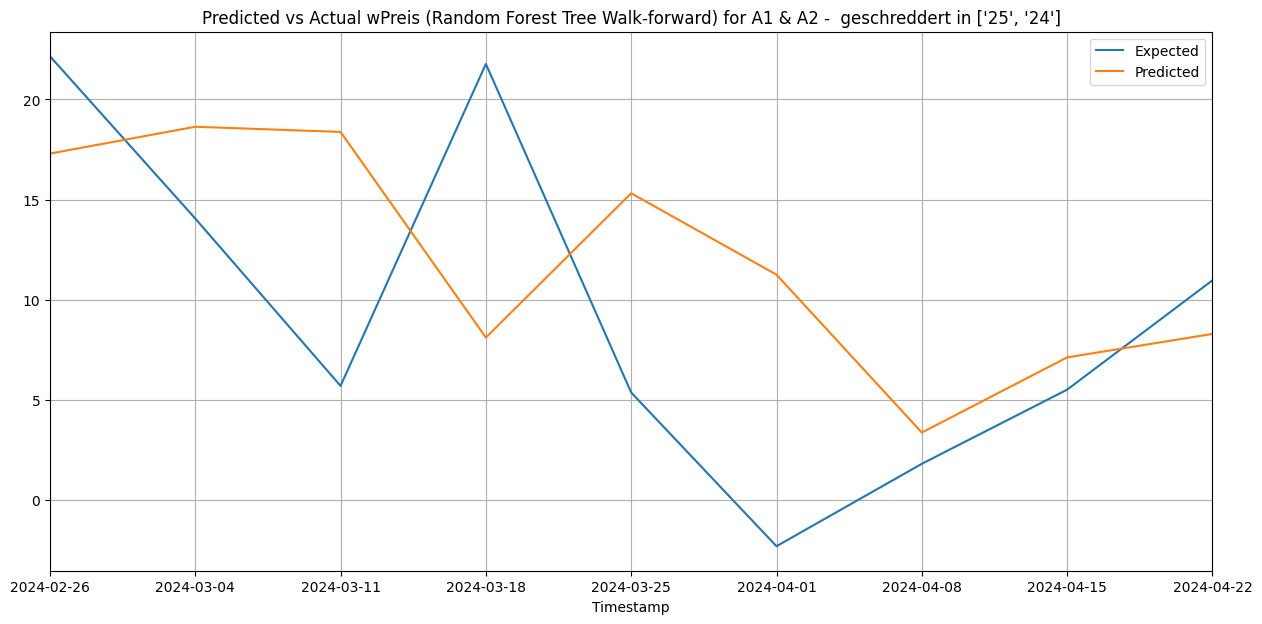

In [295]:
# evaluate
wf_accuracy_prod = rf_walk_forward_validation(rf_data, nobs)
mae = wf_accuracy_prod['mae']
me = wf_accuracy_prod['me']
rmse = wf_accuracy_prod['rmse']
expected = wf_accuracy_prod['expected']
predictions = wf_accuracy_prod['predictions']
direction_accuracy = wf_accuracy_prod['direction_accuracy']

# evaluate
print(f'Forecast Accuracy (Random Forest Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)

# plot expected vs preducted
df_wPreis = pd.DataFrame(
    {'observations': expected,
     'forecast': predictions, 
    })
df_wPreis.index = df_test['wPreis'].index


plt.figure(figsize=(15, 7))

# Plot actual wPreis
ax1 = df_wPreis.observations.plot(grid=True, label='Expected')

# Plot predicted wPreis on secondary y-axis
# ax2 = df_wPreis.forecast.plot(grid=True, secondary_y=True, label='Predicted wPreis')
ax2 = df_wPreis.forecast.plot(grid=True, label='Predicted')

# Set x-axis ticks and labels to be the dates from the index
ax1.set_xticks(df_wPreis.index)
ax1.set_xticklabels(df_wPreis.index.strftime('%Y-%m-%d'))  # Format dates as desired

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title(f'Predicted vs Actual wPreis (Random Forest Tree Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.xlabel("Timestamp")

plt.grid(True)
plt.legend()
plt.show() 

In [296]:
results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [direction_accuracy]
}

# Convert the dictionary into a DataFrame
RandomForest_wf = pd.DataFrame(results)
RandomForest_wf

,mae,me,rmse,direction_accuracy
0,7.234147,2.525658,8.732761,0.5


In [297]:
%store RandomForest_wf

Stored 'RandomForest_wf' (DataFrame)


### Rolling forecast for Random Forest  

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [298]:
train, test = train_test_split(rf_data, nobs)


In [299]:
test

array([[14.94494128, 13.7571362 , 17.34321268, 19.08385688, 22.15590367],
       [13.7571362 , 17.34321268, 19.08385688, 22.15590367, 14.05657364],
       [17.34321268, 19.08385688, 22.15590367, 14.05657364,  5.70419682],
       [19.08385688, 22.15590367, 14.05657364,  5.70419682, 21.77178067],
       [22.15590367, 14.05657364,  5.70419682, 21.77178067,  5.37221127],
       [14.05657364,  5.70419682, 21.77178067,  5.37221127, -2.29737704],
       [ 5.70419682, 21.77178067,  5.37221127, -2.29737704,  1.8152799 ],
       [21.77178067,  5.37221127, -2.29737704,  1.8152799 ,  5.51596431],
       [ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431, 10.97189655]])

In [300]:
train = asarray(train)

In [301]:
trainX, trainy = train[:, :-1], train[:, -1]


In [302]:
model_rf_rolling = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf_rolling.fit(trainX, trainy)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [303]:
predictions = list()
direction_accuracies = list() 

In [304]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print(testX)
    yhat = model_rf_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat[0])
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[14.94494128 13.7571362  17.34321268 19.08385688]
>expected=22.2, predicted=17.3
[13.7571362  17.34321268 19.08385688 22.15590367]
>expected=14.1, predicted=18.3
[17.34321268 19.08385688 22.15590367 14.05657364]
>expected=5.7, predicted=18.9
[19.08385688 22.15590367 14.05657364  5.70419682]
>expected=21.8, predicted=8.3
[22.15590367 14.05657364  5.70419682 21.77178067]
>expected=5.4, predicted=16.8
[14.05657364  5.70419682 21.77178067  5.37221127]
>expected=-2.3, predicted=9.0
[ 5.70419682 21.77178067  5.37221127 -2.29737704]
>expected=1.8, predicted=2.4
[21.77178067  5.37221127 -2.29737704  1.8152799 ]
>expected=5.5, predicted=6.4
[ 5.37221127 -2.29737704  1.8152799   5.51596431]
>expected=11.0, predicted=8.8


In [305]:
testy

10.97189655172414

In [306]:
predictions

[17.29697807420951,
 18.27135102464485,
 18.928069138793198,
 8.34023639865189,
 16.755040943607142,
 8.953207316168905,
 2.44181774152791,
 6.396902317839401,
 8.79620882125824]

In [307]:
mae = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

Forecast Accuracy (Random Forest Rolling) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 6.894
ME: 2.346
RMSE: 8.555
Direction Accuracy: 0.375


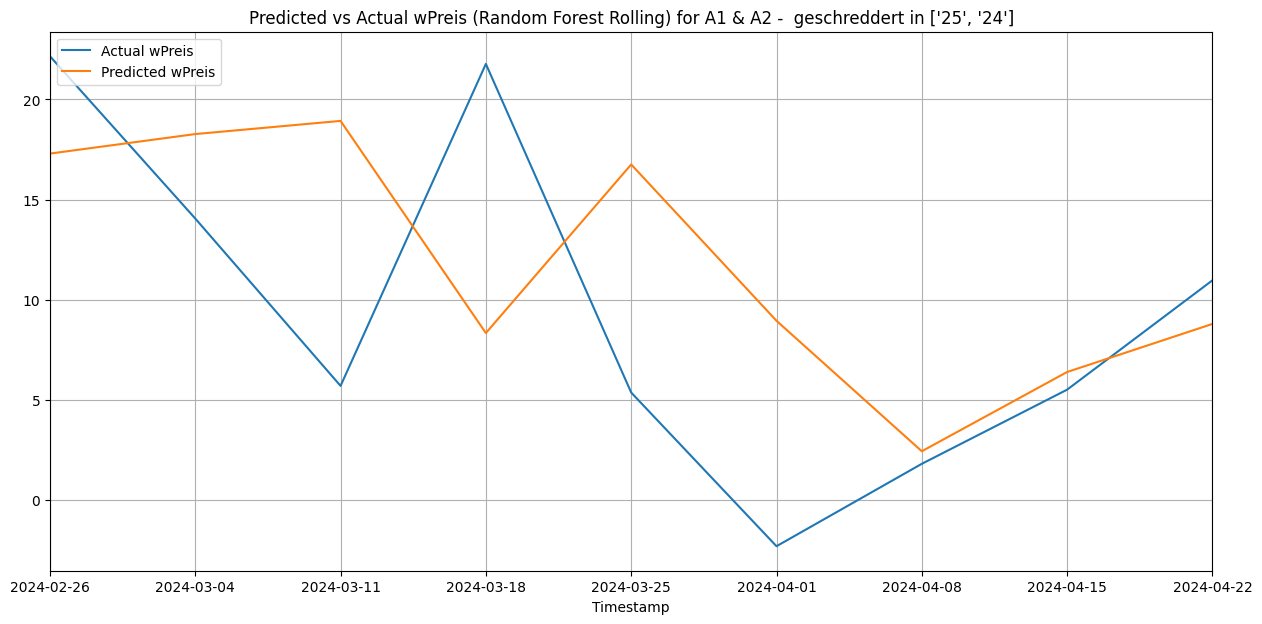

In [308]:
#print('MAE: %.3f' % mae)
print(f'Forecast Accuracy (Random Forest Rolling) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted

# evaluate
df_wPreis = pd.DataFrame(
    {'observations': test[:, -1],
     'forecast': predictions, 
    })
df_wPreis.index = df_test['wPreis'].index

# plot expected vs preducted
plt.figure(figsize=(15, 7))
plt.title(f'Predicted vs Actual wPreis (Random Forest Rolling) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
# plt.plot(test[:, -1], label='Expected')
# plt.plot(predictions, label='Predicted')
# Plot actual wPreis
ax1 = df_wPreis.observations.plot(grid=True, label='Actual wPreis')

# Plot predicted wPreis on secondary y-axis
# ax2 = df_wPreis.forecast.plot(grid=True, secondary_y=True, label='Predicted wPreis')
ax2 = df_wPreis.forecast.plot(grid=True, label='Predicted wPreis')

# Set x-axis ticks and labels to be the dates from the index
ax1.set_xticks(df_wPreis.index)
ax1.set_xticklabels(df_wPreis.index.strftime('%Y-%m-%d'))  # Format dates as desired
plt.xlabel("Timestamp")

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.grid(True)

plt.show()

In [309]:
roll_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [overall_direction_accuracy]
}

# Convert the dictionary into a DataFrame
RandomForest_roll = pd.DataFrame(roll_results)
RandomForest_roll

,mae,me,rmse,direction_accuracy
0,6.893966,2.345931,8.555033,0.375


In [310]:
%store RandomForest_roll


Stored 'RandomForest_roll' (DataFrame)


## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a
recursive autoregressive (multi-step) forecaster.

In [311]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [312]:
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4
                )

In [313]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [314]:
y_train = df_train['wPreis']

In [315]:
# Now you can pass y_train to forecaster.fit()
forecaster_rf.fit(y=y_train)

In [316]:
predicted_test = forecaster_rf.predict(steps = len(df_test))

In [317]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [318]:
predicted_test.index = df_test.index


In [319]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print(f'Forecast Accuracy (Random Forest static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])

print('MAE: %.3f' % stat_accuracy_prod['mae'])
print('ME: %.3f' % stat_accuracy_prod['me'])
print('RMSE: %.3f' % stat_accuracy_prod['rmse'])
print('Direction Accuracy: %.3f' % stat_accuracy_prod['direction_accuracy'])

# for k, v in stat_accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))




Forecast Accuracy (Random Forest static) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 9.543
ME: 6.936
RMSE: 10.814
Direction Accuracy: 0.375


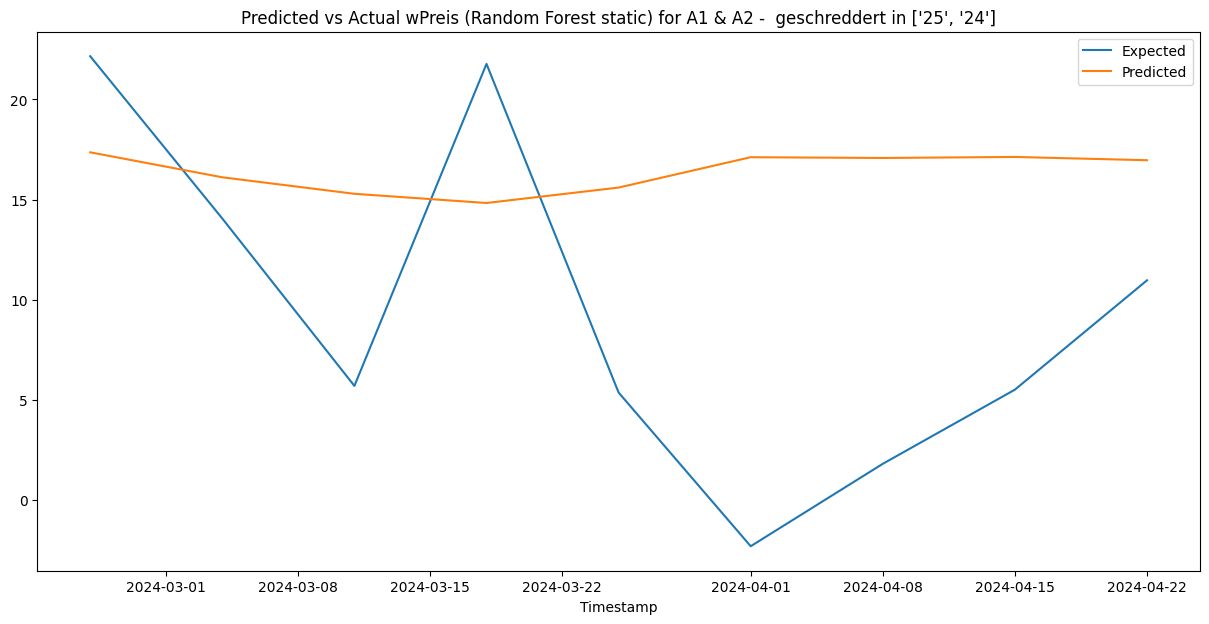

In [320]:
# plot expected vs preducted

plt.figure(figsize=(15, 7))
plt.xlabel("Timestamp")
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.title(f'Predicted vs Actual wPreis (Random Forest static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.legend()
plt.grid(True)
plt.show()

In [321]:
RandomForest_static = pd.DataFrame([stat_accuracy_prod])
RandomForest_static



,mae,me,rmse,direction_accuracy
0,9.543498,6.935595,10.814334,0.375


In [322]:
%store RandomForest_static

Stored 'RandomForest_static' (DataFrame)


## All other clusters and categories 

In [323]:
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]


    forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4
                )

    y_train = df_train['wPreis']
    forecaster_rf.fit(y=y_train)
    predicted_test = forecaster_rf.predict(steps = len(df_test))
    predicted_test.index = df_test.index
    
    return forecast_accuracy(predicted_test, df_test['wPreis'])

In [324]:
def rolling_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    rf_data = series_to_supervised(X, n_in=4)


    train, test = train_test_split(rf_data, nobs)
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]


    model_rf_rolling = RandomForestRegressor(n_estimators=1000, random_state=42)
    model_rf_rolling.fit(trainX, trainy)

    predictions = list()
    direction_accuracies = list()   

    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
        # print(testX)
        yhat = model_rf_rolling.predict([testX])
        # store forecast in list of predictions
        predictions.append(yhat)
        if i > 0:  # Direction accuracy is not applicable for the first prediction
                forecast_diff = yhat - predictions[-2]
                actual_diff = testy - test[i - 1, -1]
                direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
                direction_accuracies.append(direction_accuracy)
    

    mae = mean_absolute_error(test[:, -1], predictions)
    me = np.mean(predictions - test[:, -1])  # Mean Error
    rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    overall_direction_accuracy = np.mean(direction_accuracies)

    return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': overall_direction_accuracy}

In [325]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)

    # print(f'Decision Tree Walk-forward forecast Accuracy of: wPreis in {cluster} for {category}')
    wf_accuracy_prod = rf_walk_forward_validation(dt_data, nobs)
    # mae, me, rmse, y, yhat, direction_accuracy = 
    return wf_accuracy_prod



In [326]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [327]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')

In [328]:
data = []
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    rolling_forecast(dataset)
    wf_forecast(dataset)
    static_results = static_forecast(dataset)
    rolling_results = rolling_forecast(dataset)
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'RandomForest_static_mae': static_results['mae'],
        'RandomForest_static_me': static_results['me'],
        'RandomForest_static_rmse': static_results['rmse'],
        'RandomForest_static_direction_accuracy': static_results['direction_accuracy'],
        'RandomForest_rolling_mae': rolling_results['mae'],
        'RandomForest_rolling_me': rolling_results['me'],
        'RandomForest_rolling_rmse': rolling_results['rmse'],
        'RandomForest_rolling_direction_accuracy': rolling_results['direction_accuracy'],
        'RandomForest_wf_mae': wf_results['mae'],
        'RandomForest_wf_me': wf_results['me'],
        'RandomForest_wf_rmse': wf_results['rmse'],
        'RandomForest_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
# df_results


In [329]:
df_results.to_csv('RandomForest_Results.csv')

In [330]:
df_metrics = df_results[['Cluster', 'Category', 'RandomForest_static_rmse', 'RandomForest_rolling_rmse',  'RandomForest_wf_rmse', 'RandomForest_static_direction_accuracy', 'RandomForest_rolling_direction_accuracy', 'RandomForest_wf_direction_accuracy']]

In [331]:
def getRMSEplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.25

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_rmse = df_plot['RandomForest_static_rmse']
    rolling_rmse = df_plot['RandomForest_rolling_rmse']
    wf_rmse = df_plot['RandomForest_wf_rmse']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_rmse, bar_width, label='Static RMSE')
    ax.barh([x + bar_width for x in ind], rolling_rmse, bar_width, label='Rolling RMSE')
    ax.barh([x + 2*bar_width for x in ind], wf_rmse, bar_width, label='Walk-forward RMSE')

    # Add RMSE values next to each bar
    for i, (s_rmse, r_rmse, wf_rmse) in enumerate(zip(static_rmse, rolling_rmse, wf_rmse)):
        ax.text(s_rmse, i, f'{s_rmse:.2f}', ha='right', va='center')
        ax.text(r_rmse, i + bar_width, f'{r_rmse:.2f}', ha='right', va='center')
        ax.text(wf_rmse, i + 2*bar_width, f'{wf_rmse:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('RMSE')
    ax.set_ylabel('Cluster')
    ax.set_title(f'RMSE comparison of Static, Rolling and Walk-forward RandomForest across clusters for {df_plot["Category"].iloc[0]}')

    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    # Show plot
    plt.show()

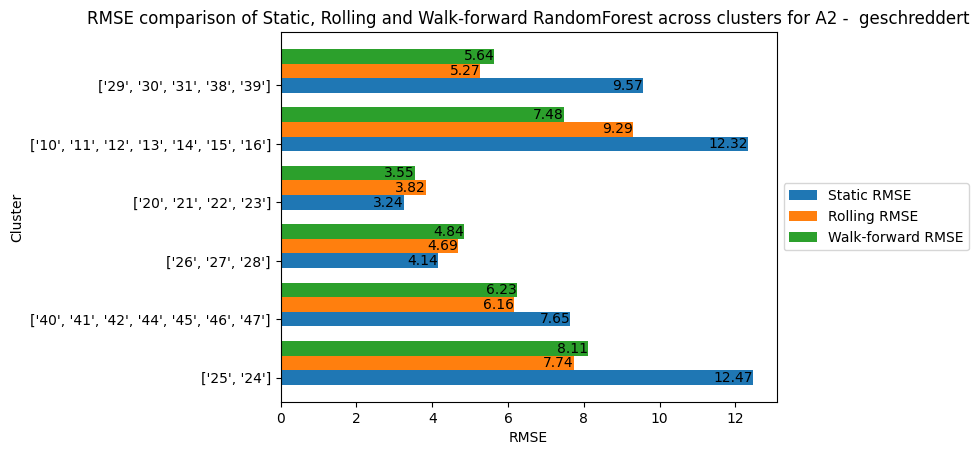

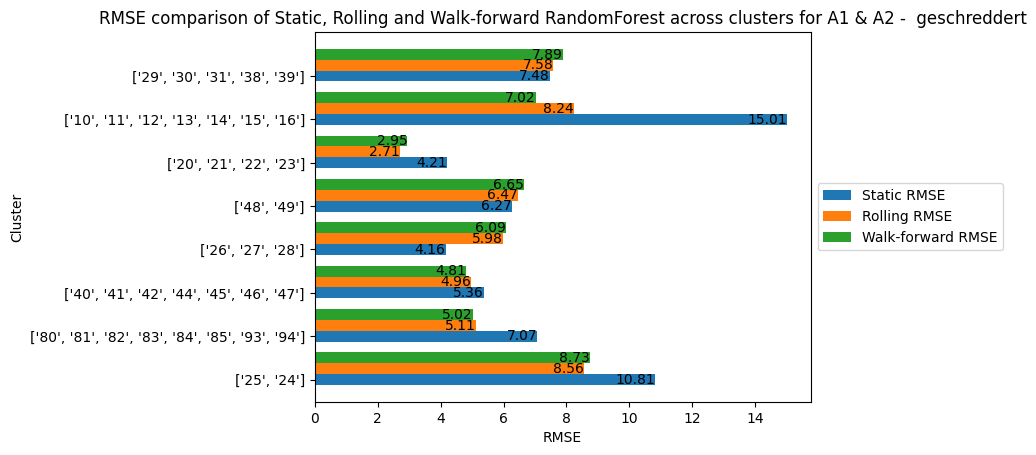

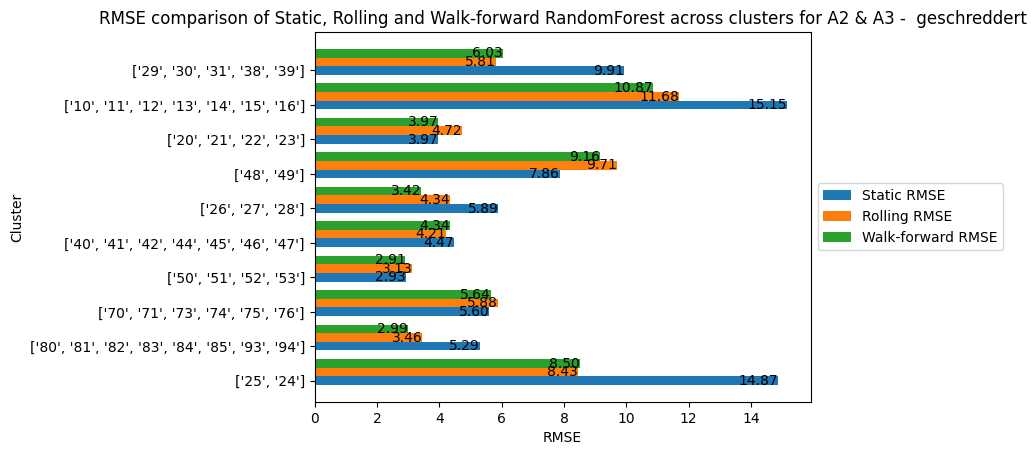

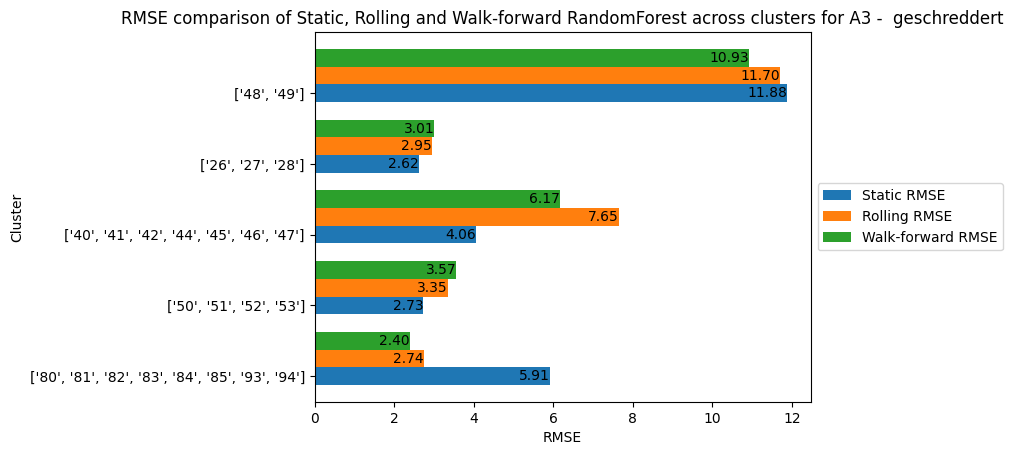

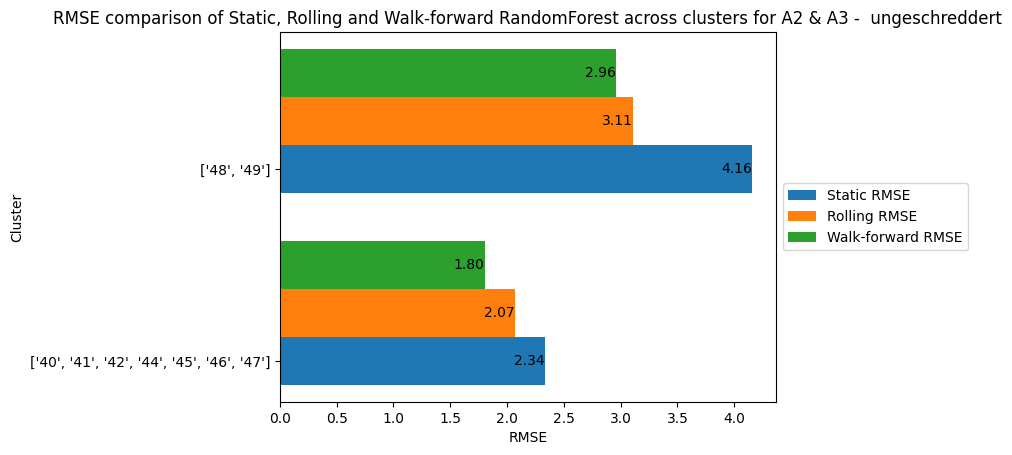

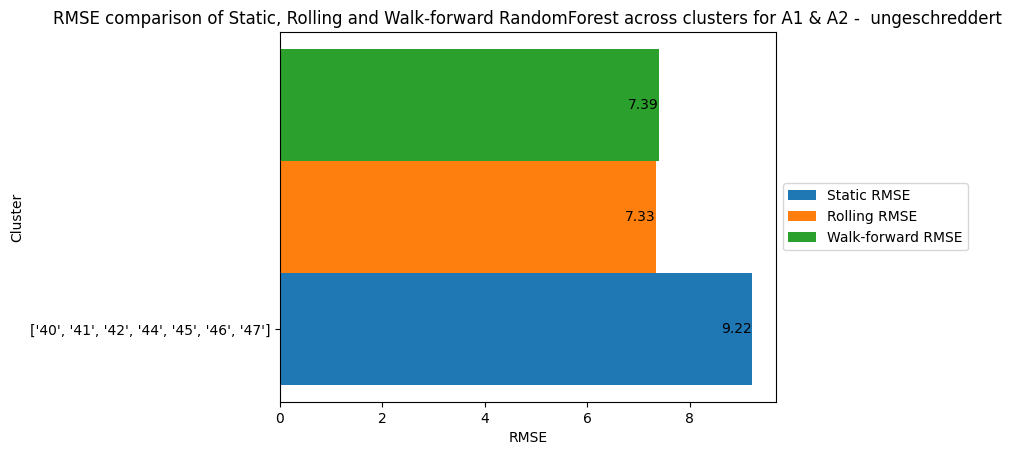

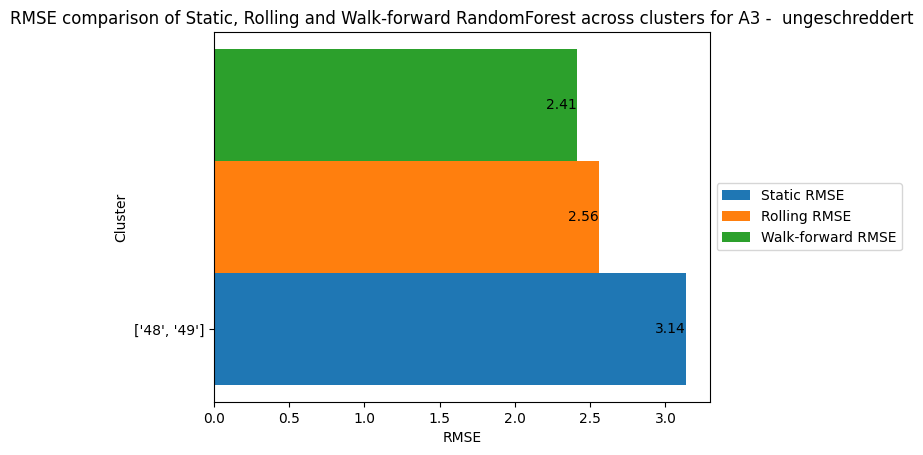

In [332]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)
    

In [333]:
def getDirAccplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.25

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_dir_acc = df_plot['RandomForest_static_direction_accuracy']
    rolling_dir_acc = df_plot['RandomForest_rolling_direction_accuracy']
    wf_dir_acc = df_plot['RandomForest_wf_direction_accuracy']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_dir_acc, bar_width, label='Static Direction Accuracy')
    ax.barh([x + bar_width for x in ind], rolling_dir_acc, bar_width, label='Rolling Direction Accuracy')
    ax.barh([x + 2*bar_width for x in ind], wf_dir_acc, bar_width, label='Walk-forward Direction Accuracy')

    # Add direction accuracy values next to each bar
    for i, (s_dir_acc, r_dir_acc, wf_dir_acc) in enumerate(zip(static_dir_acc, rolling_dir_acc, wf_dir_acc)):
        ax.text(s_dir_acc, i, f'{s_dir_acc:.2f}', ha='right', va='center')
        ax.text(r_dir_acc, i + bar_width, f'{r_dir_acc:.2f}', ha='right', va='center')
        ax.text(wf_dir_acc, i + 2*bar_width, f'{wf_dir_acc:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('Direction Accuracy')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Direction accuracy comparison of Static, Rolling and Walk-forward RandomForest across clusters for {df_plot["Category"].iloc[0]}')

    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show plot
    plt.show()

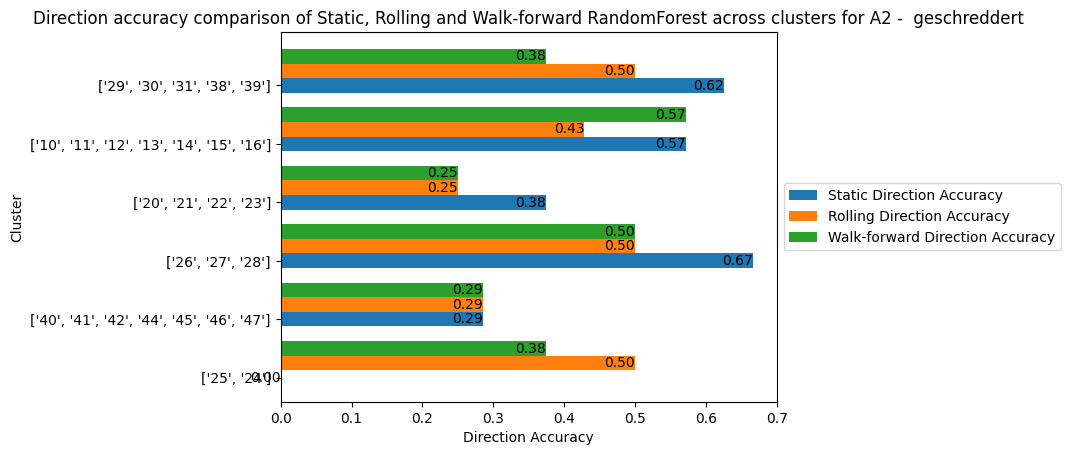

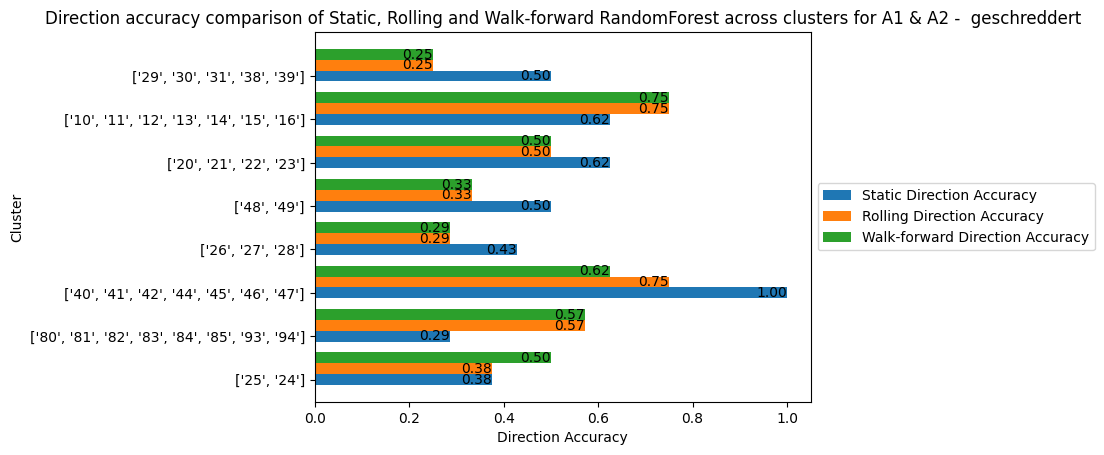

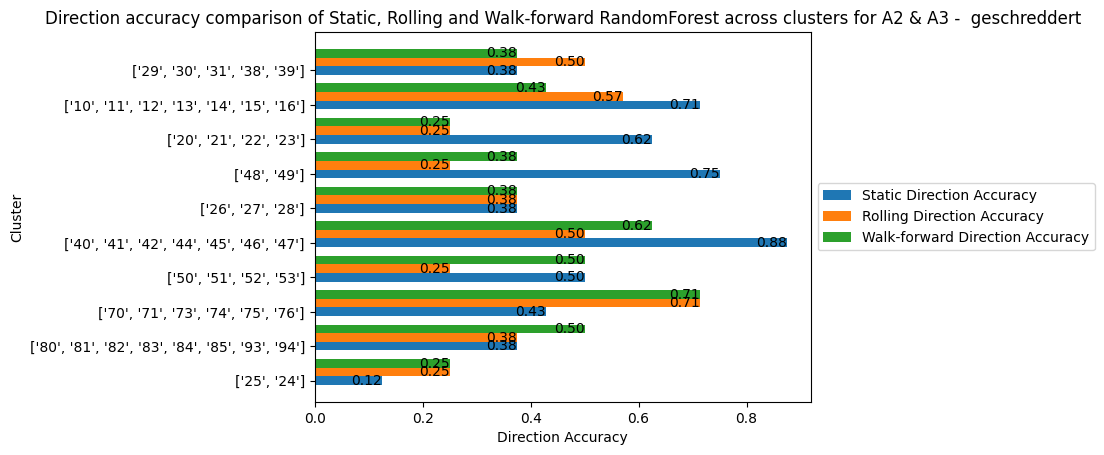

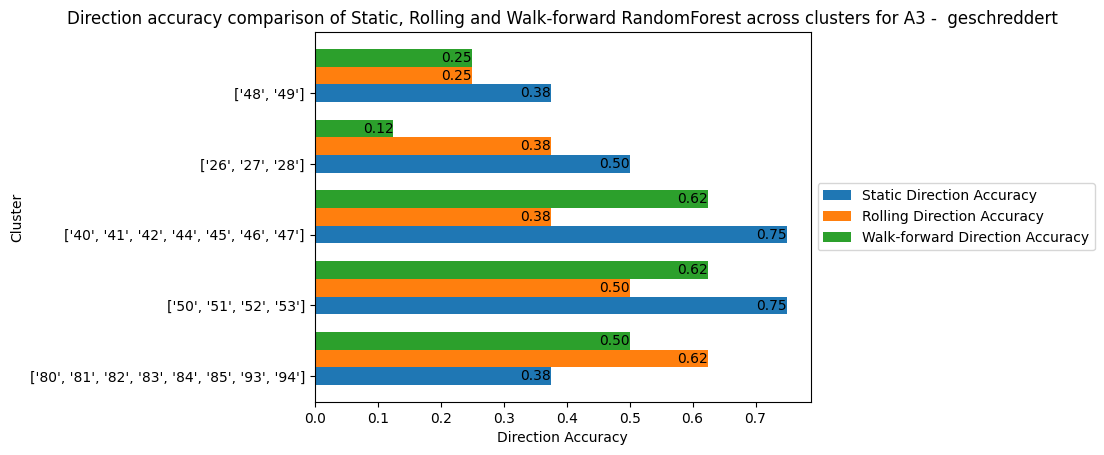

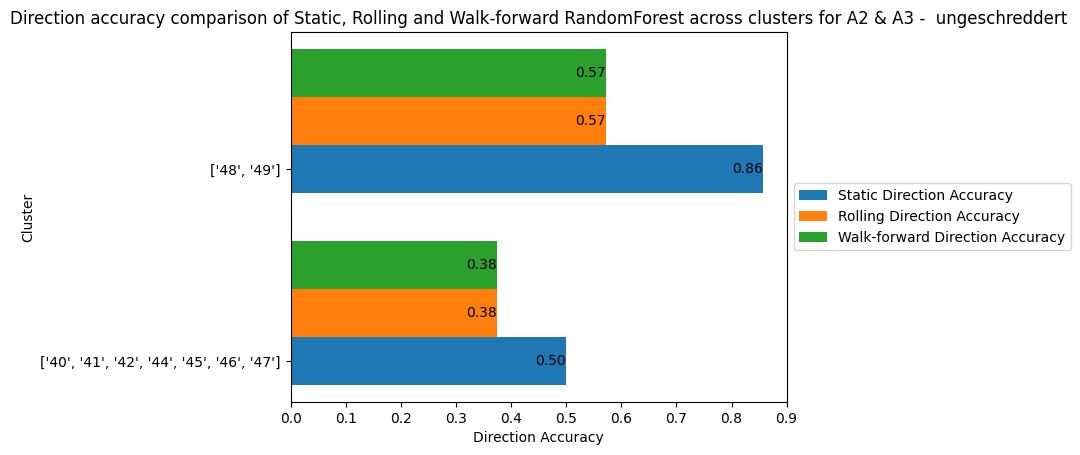

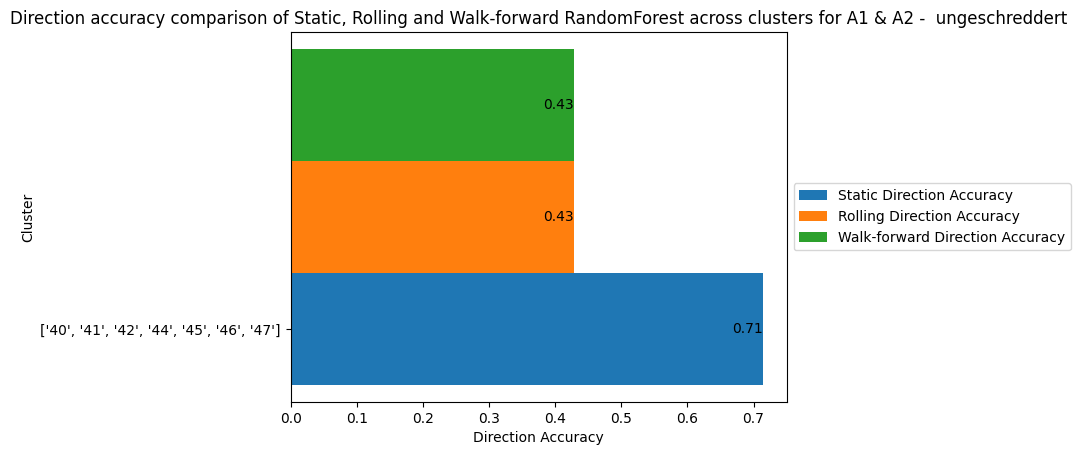

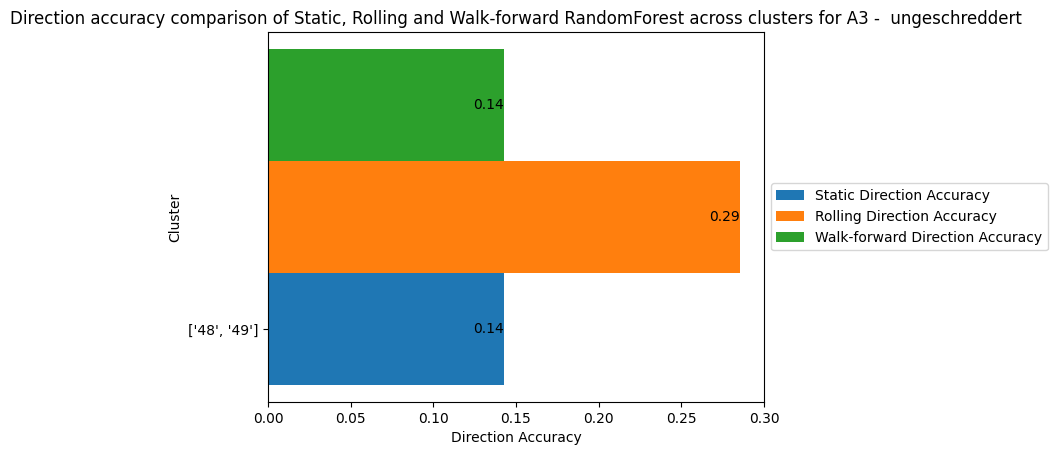

In [334]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getDirAccplot(filtered)

for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getDirAccplot(filtered)

PLOTLY GRAPHS FOR THE SAME

In [335]:
def getRMSEplot(df_plot):
    traces = []
    for metric in ['RandomForest_static_rmse', 'RandomForest_rolling_rmse',  'RandomForest_wf_rmse']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of RandomForest RMSE for Static, Rolling and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='RMSE'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [336]:
def getDirAccplot(df_plot):
    traces = []
    for metric in ['RandomForest_static_direction_accuracy', 'RandomForest_rolling_direction_accuracy', 'RandomForest_wf_direction_accuracy']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Direction Accuracy using RandomForest between Static, Rolling and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='Direction Accuracy'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [337]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)
    getDirAccplot(filtered)